# 🧬 RNAcentral Data Retrieval: tRNA-Sec Pipeline

This notebook documents a reproducible workflow to fetch, enrich, and analyze 
**tRNA-Sec sequences** from RNAcentral.  
It is divided into the following steps:

1. **Setup** → Import functions and prepare environment  
2. **Fetch** → Retrieve sequences from RNAcentral  
3. **Enrich** → Add gene annotations and metadata  
4. **Export** → Save curated datasets  
5. **Pipeline** → Run everything in one go  
6. **Exploratory Analysis** → Inspect and visualize results


## === 1. Setup ===

We start by importing the functions defined in `scripts/fetch_rnacentral.py`.  
Since this notebook may be executed in different environments (VSCode, Colab),  
we use `importlib` to load the file explicitly by its relative path.  

This guarantees that the functions are available even if `sys.path` is not configured. 

In [15]:
# Import project functions and set working directory

import importlib.util
import sys

# Load module from relative path
spec = importlib.util.spec_from_file_location(
    "fetch_rnacentral", "../scripts/fetch_rnacentral.py"
)
fr_module = importlib.util.module_from_spec(spec)
sys.modules["fetch_rnacentral"] = fr_module
spec.loader.exec_module(fr_module)

# Now we can call functions as fr_module.function_name

## === 2. Fetch sequences ===

We start by querying RNAcentral for **selenocysteine tRNAs**.  
This step retrieves nucleotide sequences along with basic metadata 
(e.g. species, RNA type, expert database source).  

We limit the query to 20 entries as a test, before scaling up.

In [16]:
df_sample = fr_module.fetch_all_trna_sec(max_results=20)
print(f"✅ Retrieved {len(df_sample)} sequences")
df_sample.head()

📋 Query: tRNA AND so_rna_type_name:"Selenocysteinyl_tRNA"
⚡ Encontrados 43902 resultados
⚡ Obteniendo 20 de 43902 resultados


Extrayendo secuencias: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]

✅ Retrieved 20 sequences


,URS_ID,Sequence,Length,description,species,rna_type,so_rna_type_name,expert_db,length
0,URS00001DA281_9606,GCCCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,87,Homo sapiens (human) tRNA-SeC (anticodon TCA) ...,Homo sapiens,tRNA,selenocysteinyl_tRNA,ENA; HGNC; GeneCards; MalaCards; GtRNAdb; PDBe,87
1,URS0000C8E9EB_9606,GCUCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,84,Homo sapiens (human) tRNA-SeC (anticodon TCA) ...,Homo sapiens,tRNA,selenocysteinyl_tRNA,GtRNAdb; HGNC; GeneCards,84
2,URS00008FED48_9606,GGCCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,90,selenocysteine tRNA from Homo sapiens (PDB 4RQ...,Homo sapiens,tRNA,selenocysteinyl_tRNA,PDBe,90
3,URS000014E598_9606,GCCCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,90,human Ser-tRNA-Sec from Homo sapiens (PDB 7ZJW...,Homo sapiens,tRNA,selenocysteinyl_tRNA,PDBe,90
4,URS00006501FF_9606,GCUCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,87,Homo sapiens (human) Selenocysteine transfer RNA,Homo sapiens,tRNA,selenocysteinyl_tRNA,Rfam,87


# === 3. Enrich with Gene Information ===

RNAcentral provides additional gene annotations and references.  
Here we extend the DataFrame by querying the API again for each URS_ID,  
adding information on **associated genes** and **publication counts**.  

In [17]:
df_full = fr_module.enrich_with_genes(df_sample)

print(f"✅ Enriched dataset with {df_full.shape[1]} columns")

df_full.head()

Enriqueciendo con genes: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]

✅ Enriched dataset with 11 columns


,URS_ID,Sequence,Length,description,species,rna_type,so_rna_type_name,expert_db,length,genes,publications
0,URS00001DA281_9606,GCCCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,87,Homo sapiens (human) tRNA-SeC (anticodon TCA) ...,Homo sapiens,tRNA,selenocysteinyl_tRNA,ENA; HGNC; GeneCards; MalaCards; GtRNAdb; PDBe,87,TRU-TCA1-1; tRNA-SeC-TCA-1-1; tRNA-Ser,120
1,URS0000C8E9EB_9606,GCUCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,84,Homo sapiens (human) tRNA-SeC (anticodon TCA) ...,Homo sapiens,tRNA,selenocysteinyl_tRNA,GtRNAdb; HGNC; GeneCards,84,TRU-TCA2-1; tRNA-SeC-TCA-2-1,7
2,URS00008FED48_9606,GGCCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,90,selenocysteine tRNA from Homo sapiens (PDB 4RQ...,Homo sapiens,tRNA,selenocysteinyl_tRNA,PDBe,90,,18
3,URS000014E598_9606,GCCCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,90,human Ser-tRNA-Sec from Homo sapiens (PDB 7ZJW...,Homo sapiens,tRNA,selenocysteinyl_tRNA,PDBe,90,,29
4,URS00006501FF_9606,GCUCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,87,Homo sapiens (human) Selenocysteine transfer RNA,Homo sapiens,tRNA,selenocysteinyl_tRNA,Rfam,87,,11


# === 4. Export results ===


We export two CSVs:  
1. **Sequences + Gene annotations** → curated dataset  
2. **Publications** → associated literature for each sequence  

This ensures reproducibility and allows sharing downstream.  

In [18]:
df_full.to_csv("../data/raw/sample_trna_sec.csv", index=False)
fr_module.export_publications(df_full, "../data/raw/sample_trna_sec_publications.csv")

Extrayendo publicaciones: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s]

✅ Publicaciones guardadas en: ../data/raw/sample_trna_sec_publications.csv


# === 5. Run full pipeline (optional) ===

For convenience, we provide a single function `run_full_pipeline()`  
that runs all previous steps automatically:

1. Fetch tRNA-Sec sequences  
2. Enrich with gene info  
3. Export results and publications  

Useful for larger queries or automation.

In [19]:
df_full = fr_module.run_full_pipeline(maxsize=500, outdir="../data/raw")

print("✅ Full pipeline executed")

df_full.head()


=== Fetching tRNA-Sec with full metadata ===
📋 Query: tRNA AND so_rna_type_name:"Selenocysteinyl_tRNA"
⚡ Encontrados 43902 resultados
⚡ Obteniendo 500 de 43902 resultados


Enriqueciendo con genes: 100%|██████████| 500/500 [09:38<00:00,  1.16s/it]


✅ Final CSV with genes saved to: ../data/raw\500_trna_sec.csv


Extrayendo publicaciones: 100%|██████████| 500/500 [01:27<00:00,  5.71it/s]

✅ Publicaciones guardadas en: ../data/raw\500_trna_sec_publications.csv
✅ Full pipeline executed


,URS_ID,Sequence,Length,description,species,rna_type,so_rna_type_name,expert_db,length,genes,publications
0,URS00001DA281_9606,GCCCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,87,Homo sapiens (human) tRNA-SeC (anticodon TCA) ...,Homo sapiens,tRNA,selenocysteinyl_tRNA,ENA; HGNC; GeneCards; MalaCards; GtRNAdb; PDBe,87,TRU-TCA1-1; tRNA-SeC-TCA-1-1; tRNA-Ser,120
1,URS0000C8E9EB_9606,GCUCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,84,Homo sapiens (human) tRNA-SeC (anticodon TCA) ...,Homo sapiens,tRNA,selenocysteinyl_tRNA,GtRNAdb; HGNC; GeneCards,84,TRU-TCA2-1; tRNA-SeC-TCA-2-1,7
2,URS00008FED48_9606,GGCCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,90,selenocysteine tRNA from Homo sapiens (PDB 4RQ...,Homo sapiens,tRNA,selenocysteinyl_tRNA,PDBe,90,,18
3,URS000014E598_9606,GCCCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,90,human Ser-tRNA-Sec from Homo sapiens (PDB 7ZJW...,Homo sapiens,tRNA,selenocysteinyl_tRNA,PDBe,90,,29
4,URS00006501FF_9606,GCUCGGAUGAUCCUCAGUGGUCUGGGGUGCAGGCUUCAAACCUGUA...,87,Homo sapiens (human) Selenocysteine transfer RNA,Homo sapiens,tRNA,selenocysteinyl_tRNA,Rfam,87,,11


# === 6. Exploratory Analysis ✨ ===

Now that we have a curated dataset, let’s explore its structure.  
We aim to answer:  

- What is the **distribution of sequence lengths**?  
- Which are the **top species** represented?  
- How many **genes per species** are annotated?  

These exploratory visualizations provide quick biological insights 
and also serve as a sanity check of the data.


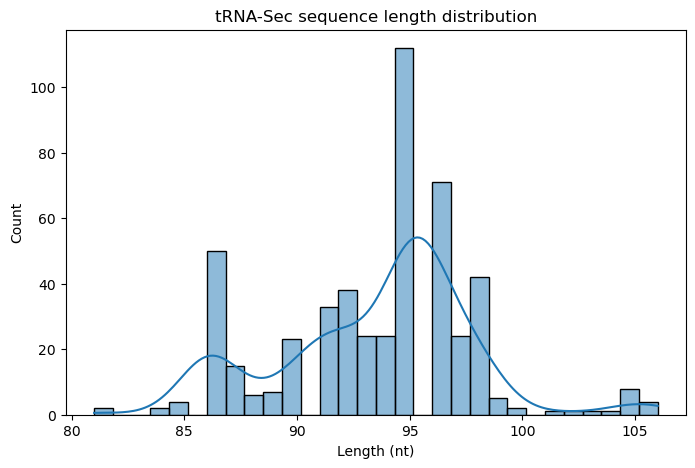

C:\Users\ro-ma\AppData\Local\Temp\ipykernel_26852\2107898551.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ro-ma\AppData\Local\Temp\ipykernel_26852\2107898551.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


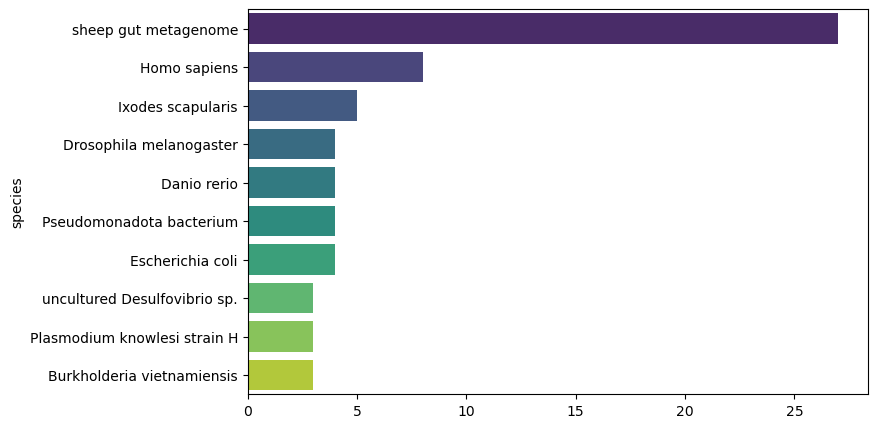

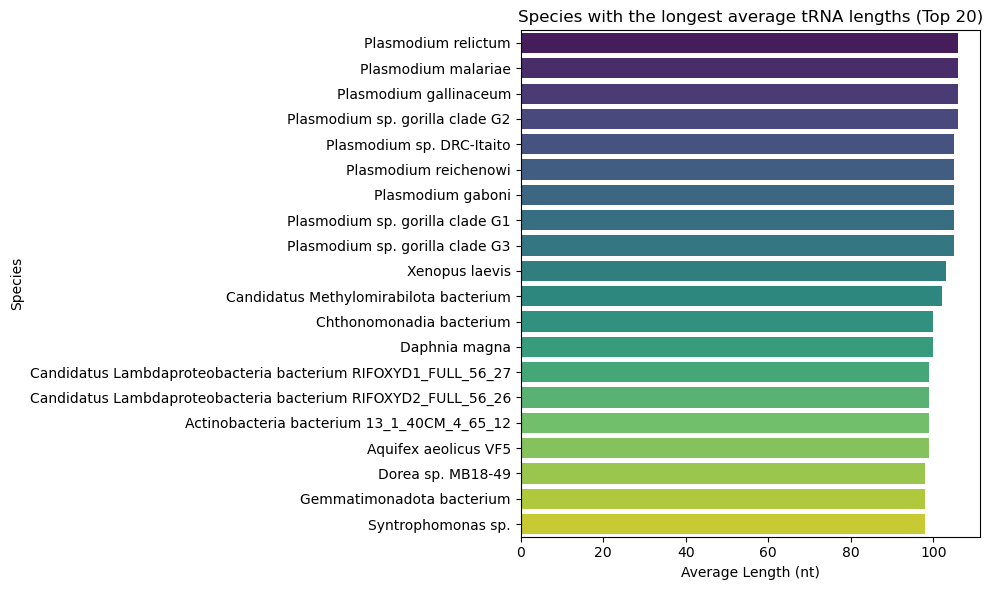

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# === Distribution of sequence lengths ===
plt.figure(figsize=(8,5))
sns.histplot(df_full["Length"], bins=30, kde=True)
plt.title("tRNA-Sec sequence length distribution")
plt.xlabel("Length (nt)")
plt.ylabel("Count")
plt.show()

# === Top 10 species by sequence count ===
top_species = df_full["species"].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(
    x=top_species.values,
    y=top_species.index,
    dodge=False,
    palette="viridis",
    legend=False               
)

# === Top 20 species with longest average tRNA length ===
top_species = mean_lengths.sort_values("Length", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_species,
    x="Length",
    y="species",
    palette="viridis"
)
plt.title("Species with the longest average tRNA lengths (Top 20)")
plt.xlabel("Average Length (nt)")
plt.ylabel("Species")
plt.tight_layout()
plt.show()